## Import Libraries

In [1]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split

## Import Env File

In [2]:
from dotenv import load_dotenv  

load_dotenv()
datasets_path = os.getenv('DATASET_PATH')
models_path = os.getenv('MODELS_PATH')

## Device Configuration

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Hyperparameters

In [8]:
num_classes = 2  
batch_size = 16
test_split_ratio = 0.2
image_size = (224, 224)

## Data Preprocessing

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


## Data Loaders

In [9]:
# Ambil dataset utama tanpa transform dulu
dataset = datasets.ImageFolder(root=datasets_path, transform=transform)

# Split dataset
test_size = int(test_split_ratio * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoader untuk training dan testing
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [10]:
# Cetak semua label kelas di dalam dataset
print("Daftar kelas dalam dataset:")
print(dataset.classes)

Daftar kelas dalam dataset:
['jogja', 'pekalongan']


## load Pre-Trained Model

In [11]:
class EfficientNetCustom(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetCustom, self).__init__()

        # Load EfficientNetB0 pretrained backbone
        self.base_model = models.efficientnet_b0(pretrained=True)

        # Ambil semua layer kecuali classifier
        self.features = self.base_model.features
        self.avgpool = self.base_model.avgpool
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(self.base_model.classifier[1].in_features, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)      # flatten semua kecuali batch dim
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Train The Model

In [12]:
# Loss and optimizer
model = EfficientNetCustom(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0015
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Inisialisasi early stopping
best_loss = float('inf')
epochs_no_improve = 0
early_stop_patience = 5
num_epochs = 60

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Hitung rata-rata loss untuk epoch ini
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Logika Early Stopping
    if epoch_loss < best_loss - 1e-4:
        best_loss = epoch_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stop_patience:
        print(f"⛔ Early stopping triggered at epoch {epoch+1}")
        break

c:\Users\albia\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\albia\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/60], Loss: 0.7016
Epoch [2/60], Loss: 0.6679
Epoch [3/60], Loss: 0.6383
Epoch [4/60], Loss: 0.6182
Epoch [5/60], Loss: 0.5928
Epoch [6/60], Loss: 0.5807
Epoch [7/60], Loss: 0.5289
Epoch [8/60], Loss: 0.5009
Epoch [9/60], Loss: 0.4838
Epoch [10/60], Loss: 0.4608
Epoch [11/60], Loss: 0.4145
Epoch [12/60], Loss: 0.3829
Epoch [13/60], Loss: 0.3588
Epoch [14/60], Loss: 0.3430
Epoch [15/60], Loss: 0.3583
Epoch [16/60], Loss: 0.2956
Epoch [17/60], Loss: 0.2740
Epoch [18/60], Loss: 0.2511
Epoch [19/60], Loss: 0.2003
Epoch [20/60], Loss: 0.1820
Epoch [21/60], Loss: 0.1765
Epoch [22/60], Loss: 0.1531
Epoch [23/60], Loss: 0.1743
Epoch [24/60], Loss: 0.1128
Epoch [25/60], Loss: 0.1230
Epoch [26/60], Loss: 0.1025
Epoch [27/60], Loss: 0.1001
Epoch [28/60], Loss: 0.0769
Epoch [29/60], Loss: 0.0946
Epoch [30/60], Loss: 0.0600
Epoch [31/60], Loss: 0.0746
Epoch [32/60], Loss: 0.0922
Epoch [33/60], Loss: 0.0785
Epoch [34/60], Loss: 0.0504
Epoch [35/60], Loss: 0.0622
Epoch [36/60], Loss: 0.0945
E

## Evaluation

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Evaluasi klasifikasi
print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.8889    0.8889    0.8889        27
           1     0.7500    0.7500    0.7500        12

    accuracy                         0.8462        39
   macro avg     0.8194    0.8194    0.8194        39
weighted avg     0.8462    0.8462    0.8462        39



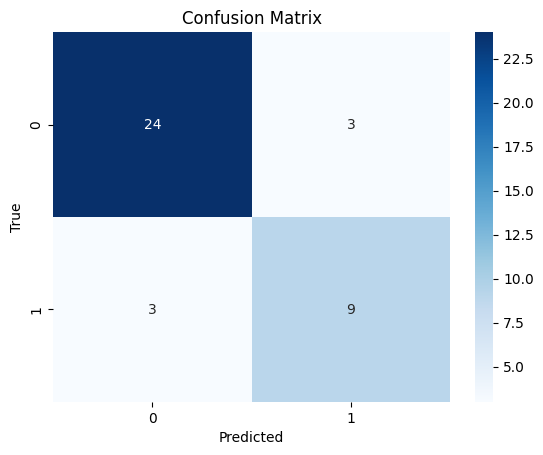

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Save The Model

In [15]:
torch.save(model.state_dict(), models_path+'/CNN.pth')